Optimization terminated successfully.
         Current function value: 0.451730
         Iterations 6
===== Initial Logistic Regression Model =====
                                Logit Regression Results                               
Dep. Variable:     Likely_to_Change_Occupation   No. Observations:                38444
Model:                                   Logit   Df Residuals:                    38424
Method:                                    MLE   Df Model:                           19
Date:                         Sun, 15 Dec 2024   Pseudo R-squ.:                  0.3370
Time:                                 19:11:26   Log-Likelihood:                -17366.
converged:                                True   LL-Null:                       -26195.
Covariance Type:                     nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

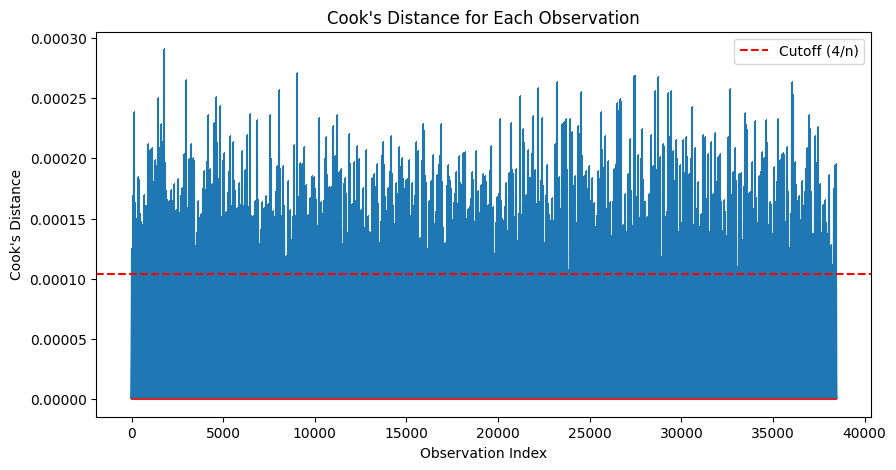

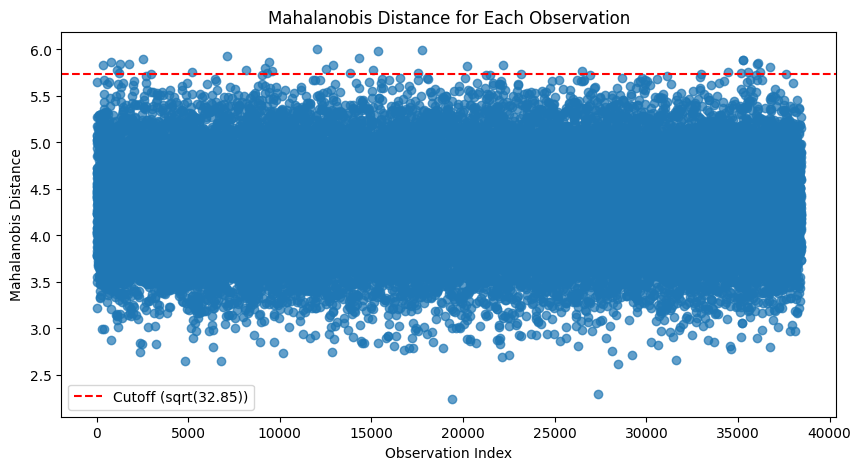

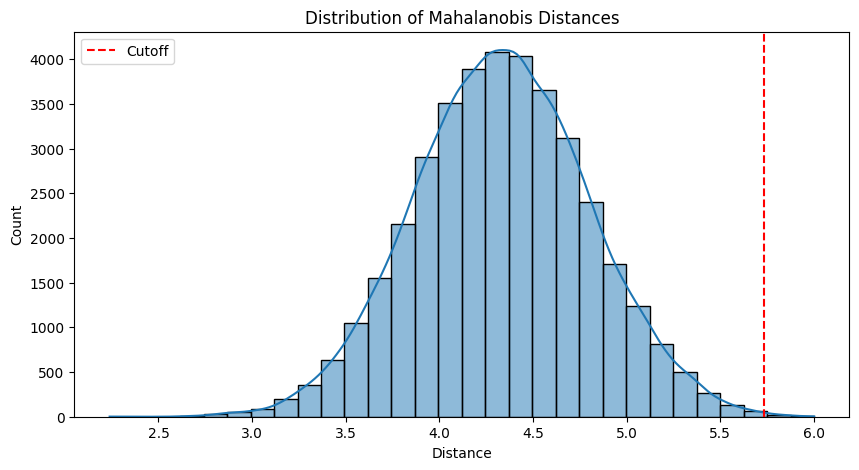

Optimization terminated successfully.
         Current function value: 0.320742
         Iterations 7
===== Logistic Regression After Outlier Removal =====
                                Logit Regression Results                               
Dep. Variable:     Likely_to_Change_Occupation   No. Observations:                35990
Model:                                   Logit   Df Residuals:                    35970
Method:                                    MLE   Df Model:                           19
Date:                         Sun, 15 Dec 2024   Pseudo R-squ.:                  0.5319
Time:                                 19:12:00   Log-Likelihood:                -11543.
converged:                                True   LL-Null:                       -24661.
Covariance Type:                     nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

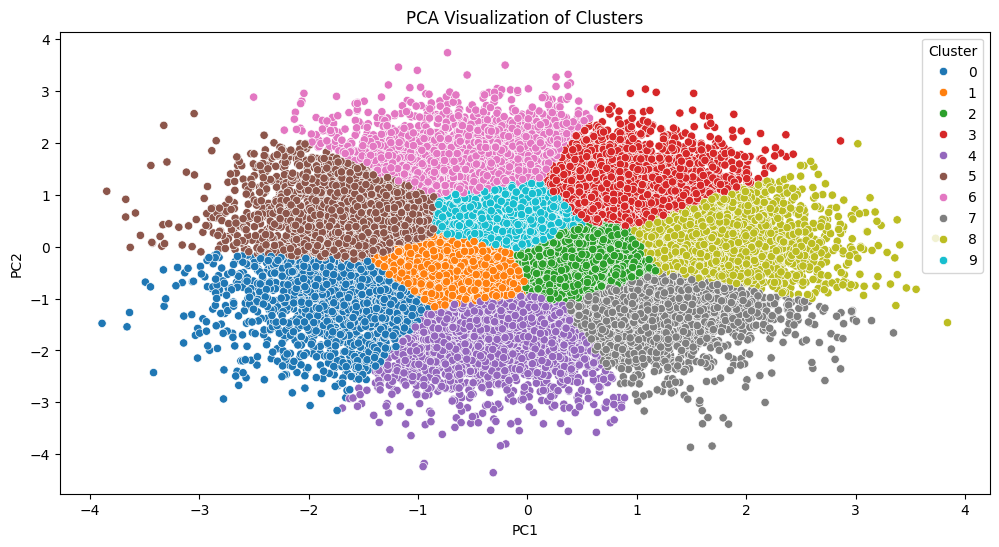

c:\Users\Fabio\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Fabio\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Fabio\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Fabio\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\Fabio\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: 

===== Mixed Effects Model Summary (Linear Approximation) =====
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Likely_to_Change_Occupation
No. Observations: 38444   Method:             REML                       
No. Groups:       10      Scale:              0.1496                     
Min. group size:  3699    Log-Likelihood:     -18167.8047                
Max. group size:  3949    Converged:          No                         
Mean group size:  3844.4                                                 
--------------------------------------------------------------------------
                         Coef.   Std.Err.     z      P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                 1.360     0.034    40.382  0.000   1.294   1.426
Age                      -0.000     0.000    -1.035  0.301  -0.001   0.000
Career_Change_Events      0.001     0.002     0.571  0.568  -0

c:\Users\Fabio\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# =====================================
# Load and Prepare Data
# =====================================
df = pd.read_csv("C:/Users/Fabio/Desktop/AMS/group/new_dataset/career_change_prediction_dataset.csv")

# Categorical mappings
education_mapping = {'High School': 1, 'PhD': 4, "Master's": 3, "Bachelor's": 2}
growth_mapping = {'High': 3, 'Low': 1, "Medium": 2}
influence_mapping = {'High': 3, 'Low': 1, "Medium": 2}
gender_mapping = {'Male': 2, 'Female': 1}

df['Education Level'] = df['Education Level'].map(education_mapping)
df['Industry Growth Rate'] = df['Industry Growth Rate'].map(growth_mapping)
df['Family Influence'] = df['Family Influence'].map(influence_mapping).fillna(0).astype(int)
df['Gender'] = df['Gender'].map(gender_mapping)

target_column = 'Likely_to_Change_Occupation'
filtered_columns = df.columns.difference(['Field of Study', 'Current Occupation', 'Career Change Interest'])
filtered_df = df.loc[:, filtered_columns]
filtered_df.columns = filtered_df.columns.str.replace(' ', '_').str.replace('-', '_')

# Construct formula
independent_vars = " + ".join(col for col in filtered_df.columns if col != target_column)
formula = f"{target_column} ~ {independent_vars}"

# =====================================
# Initial Logistic Regression
# =====================================
logit_model = smf.logit(formula, data=filtered_df).fit()
print("===== Initial Logistic Regression Model =====")
print(logit_model.summary())

original_predictions = logit_model.predict(filtered_df)
original_preds_class = (original_predictions > 0.5).astype(int)
original_accuracy = accuracy_score(filtered_df[target_column], original_preds_class)
original_auc = roc_auc_score(filtered_df[target_column], original_predictions)
print(f"Original Logistic Regression - Accuracy: {original_accuracy}, AUC: {original_auc}")

# =====================================
# Initial Random Forest
# =====================================
X = filtered_df.drop(columns=[target_column])
y = filtered_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_auc = roc_auc_score(y_test, rf_probs)
print("===== Initial Random Forest Model =====")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest AUC: {rf_auc}")

# =====================================
# Outlier Detection
# Using Cook's Distance & Mahalanobis Distance
# =====================================
outlier_model = sm.Logit.from_formula(formula, data=filtered_df).fit(disp=0)
influence = outlier_model.get_influence()
cooks_d = influence.cooks_distance[0]

X_values = X.values
mean_vec = np.mean(X_values, axis=0)
cov_mat = np.cov(X_values, rowvar=False)
inv_cov_mat = np.linalg.inv(cov_mat)
diff = X_values - mean_vec
mahal_dist = np.sqrt(np.diag(diff @ inv_cov_mat @ diff.T))

p = X_values.shape[1]
cutoff = chi2.ppf(0.975, p)  # chi-square cutoff at 97.5%

outlier_indices = np.where((cooks_d > 4/len(filtered_df)) | (mahal_dist > np.sqrt(cutoff)))[0]
print(f"Number of potential outliers: {len(outlier_indices)}")

# =====================================
# Visualization of Outliers
# =====================================

# Plot Cook's Distance
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=4/len(filtered_df), color='r', linestyle='--', label='Cutoff (4/n)')
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# Plot Mahalanobis Distance
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(mahal_dist)), mahal_dist, alpha=0.7)
plt.axhline(y=np.sqrt(cutoff), color='r', linestyle='--', label=f'Cutoff (sqrt({cutoff:.2f}))')
plt.title("Mahalanobis Distance for Each Observation")
plt.xlabel("Observation Index")
plt.ylabel("Mahalanobis Distance")
plt.legend()
plt.show()

# Optional: Distribution plot of Mahalanobis Distances
plt.figure(figsize=(10, 5))
sns.histplot(mahal_dist, kde=True, bins=30)
plt.axvline(x=np.sqrt(cutoff), color='r', linestyle='--', label='Cutoff')
plt.title("Distribution of Mahalanobis Distances")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.legend()
plt.show()

# Create a cleaned dataset without outliers
cleaned_df = filtered_df.drop(filtered_df.index[outlier_indices])

# =====================================
# Logistic Regression (Cleaned Data)
# =====================================
cleaned_logit = smf.logit(formula, data=cleaned_df).fit()
print("===== Logistic Regression After Outlier Removal =====")
print(cleaned_logit.summary())

cleaned_predictions = cleaned_logit.predict(cleaned_df)
cleaned_preds_class = (cleaned_predictions > 0.5).astype(int)
cleaned_accuracy = accuracy_score(cleaned_df[target_column], cleaned_preds_class)
cleaned_auc = roc_auc_score(cleaned_df[target_column], cleaned_predictions)
print(f"Cleaned Logistic Regression - Accuracy: {cleaned_accuracy}, AUC: {cleaned_auc}")

# =====================================
# Random Forest (Cleaned Data)
# =====================================
X_cleaned = cleaned_df.drop(columns=[target_column])
y_cleaned = cleaned_df[target_column]

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(
    X_cleaned, y_cleaned, test_size=0.3, random_state=42, stratify=y_cleaned
)
rf_model_cleaned = RandomForestClassifier(random_state=42)
rf_model_cleaned.fit(X_train_cl, y_train_cl)

rf_probs_cleaned = rf_model_cleaned.predict_proba(X_test_cl)[:, 1]
rf_preds_cleaned = (rf_probs_cleaned > 0.5).astype(int)

rf_accuracy_cleaned = accuracy_score(y_test_cl, rf_preds_cleaned)
rf_auc_cleaned = roc_auc_score(y_test_cl, rf_probs_cleaned)
print("===== Random Forest After Outlier Removal =====")
print(f"Cleaned Random Forest Accuracy: {rf_accuracy_cleaned}")
print(f"Cleaned Random Forest AUC: {rf_auc_cleaned}")

# =====================================
# Comparison Before and After Outlier Removal
# =====================================
print("===== Comparison Before and After Outlier Removal =====")
print(f"Original Logistic Regression - Accuracy: {original_accuracy:.3f}, AUC: {original_auc:.3f}")
print(f"Cleaned Logistic Regression - Accuracy: {cleaned_accuracy:.3f}, AUC: {cleaned_auc:.3f}")

print(f"Original RF - Accuracy: {rf_accuracy:.3f}, AUC: {rf_auc:.3f}")
print(f"Cleaned RF - Accuracy: {rf_accuracy_cleaned:.3f}, AUC: {rf_auc_cleaned:.3f}")

# =====================================
# PCA and Clustering
# =====================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Determine number of clusters based on domain knowledge or unique categories
if 'Field of Study' in df.columns:
    n_clusters = len(df['Field of Study'].unique())
else:
    n_clusters = 3  # Arbitrary choice if not available

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.fit_predict(X_pca)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title('PCA Visualization of Clusters')
plt.show()

# =====================================
# Optional Mixed-Effects Model Demonstration (Linear)
# =====================================
# If 'Field of Study' is present, we can try a mixed model
if 'Field of Study' in df.columns:
    from statsmodels.regression.mixed_linear_model import MixedLM
    filtered_df['Field_of_Study'] = df['Field of Study']
    # MixedLM is for linear outcomes, not logistic. For logistic mixed models, consider other packages.
    mixed_formula = f"{target_column} ~ {independent_vars}"
    mixed_model = MixedLM.from_formula(mixed_formula, groups='Field_of_Study', data=filtered_df)
    mixed_result = mixed_model.fit()
    print("===== Mixed Effects Model Summary (Linear Approximation) =====")
    print(mixed_result.summary())


Selected number of clusters based on BIC: 3


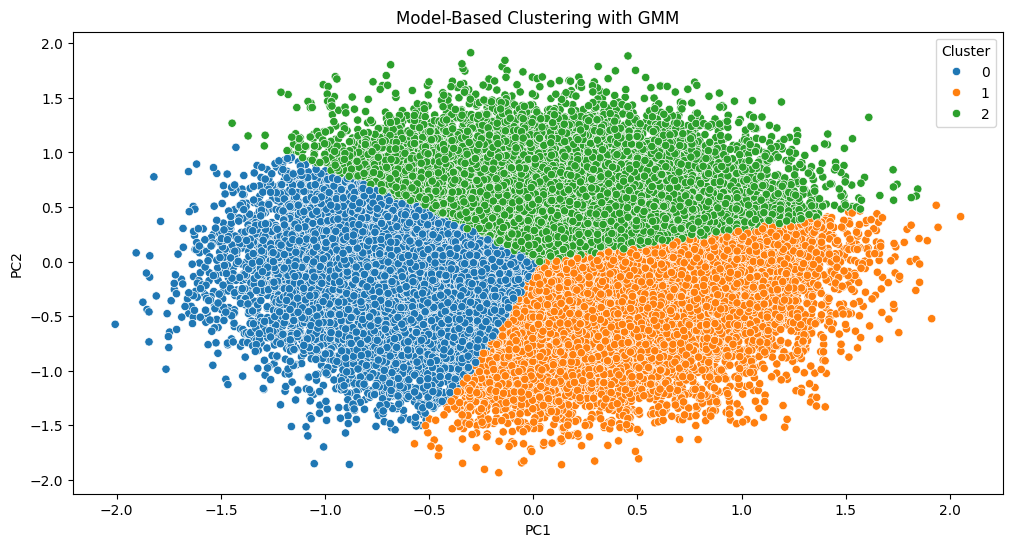

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X is your feature matrix from before
# 1. Apply robust scaling if outliers are a concern
robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)

# 2. PCA for visualization (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_robust_scaled)

# 3. Choose the number of components (clusters)
# You can use a loop to find the best number of components by comparing BIC/AIC.
lowest_bic = np.infty
best_n_components = None
n_components_range = range(1, 10)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca)
    bic = gmm.bic(X_pca)
    if bic < lowest_bic:
        lowest_bic = bic
        best_n_components = n_components

print(f"Selected number of clusters based on BIC: {best_n_components}")

# 4. Fit GMM with the best number of components
gmm = GaussianMixture(n_components=best_n_components, random_state=42)
gmm.fit(X_pca)
cluster_labels = gmm.predict(X_pca)

# 5. Plot results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(12, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title('Model-Based Clustering with GMM')
plt.show()



In [6]:
# Supponendo che 'df' contenga ancora la colonna 'Field of Study'
# e che 'pca_df' contenga i cluster assegnati come 'Cluster'

pca_df_with_field = pca_df.copy()
pca_df_with_field['Field_of_Study'] = df['Field of Study'].values

# Creiamo una tabella di contingenza
ct = pd.crosstab(pca_df_with_field['Field_of_Study'], pca_df_with_field['Cluster'])
print(ct)

# Possiamo anche calcolare le percentuali di ogni Field_of_Study all'interno di ciascun cluster
ct_percentage = ct.apply(lambda x: x / x.sum(), axis=1)
print(ct_percentage)


Cluster                    0     1     2
Field_of_Study                          
Arts                    1253  1273  1237
Biology                 1264  1320  1337
Business                1276  1301  1344
Computer Science        1228  1298  1300
Economics               1280  1210  1253
Education               1289  1257  1350
Law                     1297  1239  1315
Mechanical Engineering  1261  1302  1312
Medicine                1282  1365  1302
Psychology              1162  1219  1318
Cluster                        0         1         2
Field_of_Study                                      
Arts                    0.332979  0.338294  0.328727
Biology                 0.322367  0.336649  0.340984
Business                0.325427  0.331803  0.342770
Computer Science        0.320962  0.339258  0.339780
Economics               0.341972  0.323270  0.334758
Education               0.330852  0.322639  0.346509
Law                     0.336796  0.321735  0.341470
Mechanical Engineering  0.32541

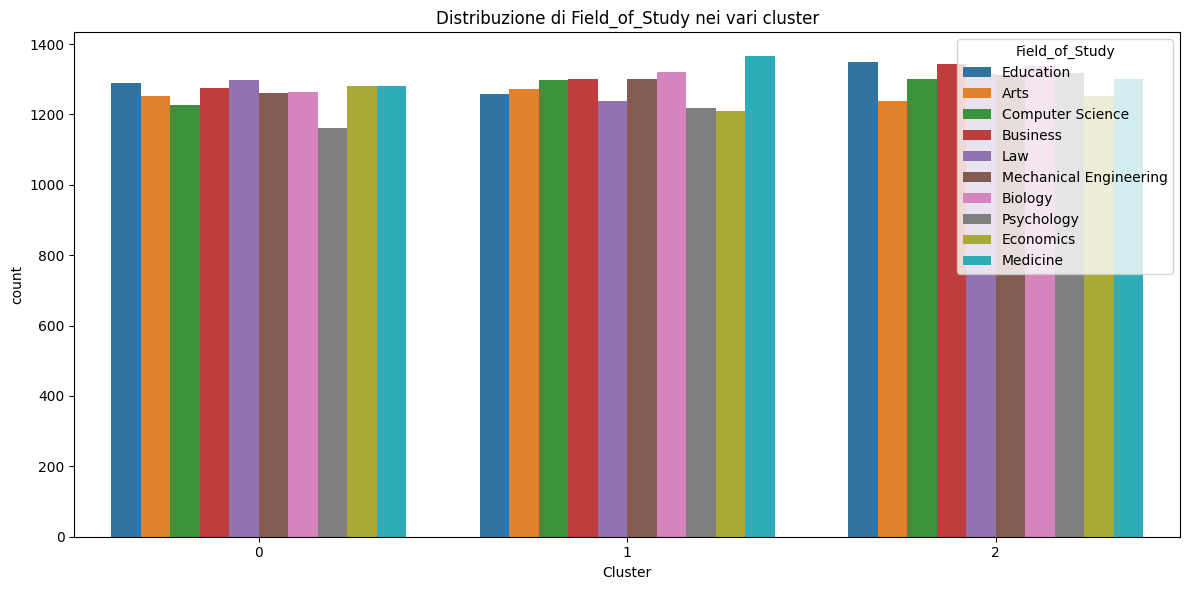

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# pca_df_with_field contiene i dati con le colonne 'Cluster' e 'Field_of_Study'
# Dato l'esempio precedente, pca_df_with_field = pca_df.copy()
# pca_df_with_field['Field_of_Study'] = df['Field of Study'].values

plt.figure(figsize=(12, 6))
sns.countplot(data=pca_df_with_field, x='Cluster', hue='Field_of_Study')
plt.title("Distribuzione di Field_of_Study nei vari cluster")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
